In [14]:
import sqlite3
import pickle
import pandas as pd

In [15]:
# Connect to sqlite database
conn = sqlite3.connect('/Users/markmorelos/DSPT7-Twitoff/twitoff.sqlite3')

In [16]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [17]:
import pickle
sql = '''
SELECT 
	tweet.id,
	tweet.tweet, 
	tweet.embedding,
	user.username
FROM tweet
JOIN user on tweet.user_id = user.id;
'''

df = get_data(sql, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x))
print(df.shape)
df.head(2)

(3840, 5)


,id,tweet,embedding,username,embedding_decoded
0,669111829205938177,The rarest of beasts - a used rocket. Controll...,b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,jeffbezos,"[-0.0891486, 0.12521237, -0.1862246, -0.056690..."
1,671461815210139648,"Breakthrough Energy Coalition. When in a box, ...",b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,jeffbezos,"[-0.048133034, 0.19431339, -0.06864032, -0.053..."


In [18]:
pickle.loads(df.embedding.iloc[0])

[-0.0891486,
 0.12521237,
 -0.1862246,
 -0.056690663,
 0.031136252,
 0.024841445,
 -0.06939763,
 -0.1037051,
 -0.06724297,
 1.8003944,
 -0.1394164,
 0.06526364,
 0.08039485,
 -0.049772188,
 -0.20953706,
 -0.116369784,
 -0.096761644,
 1.1980214,
 -0.19727543,
 -0.05336936,
 -0.07596592,
 0.035372037,
 -0.059017163,
 -0.09173835,
 -0.047808226,
 0.068631895,
 0.020181367,
 -0.13360661,
 0.12397986,
 -0.14905336,
 -0.0078535825,
 0.04751639,
 -0.041987874,
 0.10623007,
 0.07152491,
 -0.045645162,
 0.05017144,
 0.11209589,
 -0.042896364,
 -0.033788074,
 -0.106627144,
 0.058218338,
 0.01034605,
 -0.111458644,
 0.079651736,
 0.06227622,
 -0.18130776,
 0.044342216,
 0.01702674,
 0.08706171,
 -0.052796196,
 0.064050265,
 0.008463438,
 0.06069615,
 -0.024514101,
 -0.011737148,
 0.070913225,
 -0.07702421,
 0.025977978,
 -0.04617307,
 0.00059577107,
 0.053678855,
 -0.008521301,
 0.26398626,
 0.1372822,
 -0.055239774,
 -0.04517696,
 0.03718264,
 0.062594004,
 0.15019493,
 0.0023509518,
 0.01330103

In [19]:
df.username.value_counts()

nytimes            2221
jeffbezos           226
Pontifex            200
9GAG                195
CNN                 192
SpeakerPelosi       141
BarackObama         135
HillaryClinton      132
realDonaldTrump     123
UN                  118
nasa                104
WHO                  29
elonmusk             24
Name: username, dtype: int64

In [21]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username=='WHO']
user2_embeddings = df.embedding_decoded[df.username=='UN']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

# create embeddings dataframe
embeddings_df = pd.DataFrame(embeddings.to_list(),
                            columns=[f'dom{i}' for i in range(300)])
labels = np.concatenate([np.ones(len(user1_embeddings)),
                        np.zeros(len(user2_embeddings))])
print(embeddings_df.shape, labels.shape)

(147, 300) (147,)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.25, random_state=42
)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        28
         1.0       1.00      0.56      0.71         9

    accuracy                           0.89        37
   macro avg       0.94      0.78      0.82        37
weighted avg       0.91      0.89      0.88        37



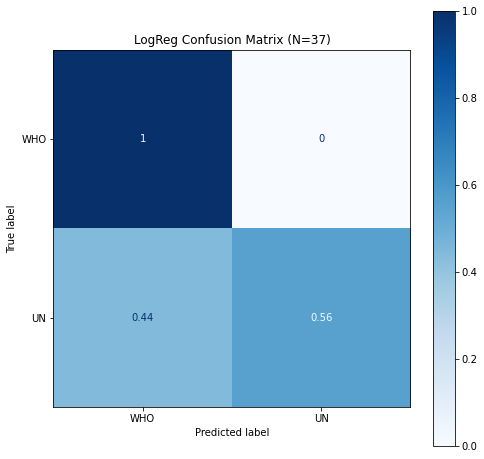

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(log_reg, X_test, y_test, 
                      normalize='true', cmap='Blues', 
                      display_labels=['WHO', 'UN'], ax=ax)
plt.title(f'LogReg Confusion Matrix (N={X_test.shape[0]})');

In [28]:
import spacy

# Load spacy pre-trained model
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser'])

def vectorize_tweet(nlp, tweet_text):
    '''This function returns the Spacy embeddings for an input text'''
    return list(nlp(tweet_text).vector)

new_embedding = vectorize_tweet(nlp, "WHO sent logistics, infection prevention, control & management experts to help strengthen hospitals & health workers capacity to fight COVID-19")
new_embedding[0:5]

[-0.16749655, 0.19911422, -0.02192038, -0.068330735, -0.15095527]

In [29]:
log_reg.predict([new_embedding])

array([0.])